In [1]:
import finite_diff as fd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
from trace_ray import trace_ray_1D
from torch_helper import torch_func
from rational_functions import fit_polynomial, fit_rational_func, SumFunc, FiniteDiffFunc1D
from gauss_freud_quad import get_nodes_and_weights
import mgo

import util as ut

In [2]:
rcParams.update(mpl.rcParamsDefault)
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 16})
rcParams['axes.titlepad'] = 20

In [3]:
# from scipy.special import hermite, factorial
# x = np.linspace(-5, 5, 1000)
# psi = lambda x, nu: (2**nu * factorial(nu))**(-1/2) * hermite(nu)(x) * np.exp(-x**2/2)

# nus = np.arange(5)
# fig, ax = plt.subplots(len(nus), 1, figsize=(8,2*len(nus)))
# for i, nu in enumerate(nus[::-1]):
#     ax[i].plot(x, psi(x, nu), 'k-')
#     ax[i].grid()
#     ax[i].set_ylim(-1.2, 1.2)
#     ax[i].set_title(r'$\nu = ' + str(nu) + '$')
# fig.tight_layout()

### Dispersion Relation

In [4]:
# def E(nu):
#     return nu + 1/2

# def R(nu):
#     return np.sqrt(2*E(nu))

# @torch_func
# def D(x: ('scalar'), k: ('scalar'), omega: ('scalar'), nu: ('scalar')):
#     return - x**2 - k**2 + 2*E(nu)

# def get_k0(x0, nu):
#     return np.sqrt(np.round(2*E(nu) - x0**2, 4))

In [5]:
# nu = 0
# x0 = -R(nu)
# k0 = get_k0(x0, nu)

In [6]:
# from scipy.special import airy

# def Ai(x):
#     ai, *_ = airy(x)
#     return ai

# def Bi(x):
#     _, _, bi, _ = airy(x)
#     return bi

# rho_ex = lambda x, nu: (R(nu)**(2/3) * np.sqrt(R(nu)**2 - x**2)) / (2**(1/3) * x)
# omega_bar_ex = lambda x, nu: (x * np.sqrt(R(nu)**2-x**2) / 2
#                           - R(nu)**2 * np.arccos(x/R(nu))/2
#                           + 2/3 * (rho_ex(x, nu)**3)
#                           + np.pi/4 * (1 - np.sign(x))
#                           )
# phi0 = lambda x0, nu: (Ai(-(rho_ex(x0, nu)**2)) * np.cos(omega_bar_ex(x0, nu)) / np.sqrt(np.abs(x0))
#                       - np.sign(x0) * Bi(-rho_ex(x0, nu)**2) * np.sin(omega_bar_ex(x0, nu)) / np.sqrt(np.abs(x0))
#                       )

In [7]:
nu = 0
E = nu + 1/2
R = np.sqrt(2*E)

@torch_func
def D(x: ('scalar'), k: ('scalar'), omega: ('scalar')):
    return - x**2 - k**2 + 2*E

def get_k0(x0):
    return np.sqrt(np.round(2*E - x0**2, 4))

nu = 0
x0 = -R
k0 = get_k0(x0)

from scipy.special import airy

def Ai(x):
    ai, *_ = airy(x)
    return ai

def Bi(x):
    _, _, bi, _ = airy(x)
    return bi

rho_ex = lambda x: (R**(2/3) * np.sqrt(R**2 - x**2)) / (2**(1/3) * x)
omega_bar_ex = lambda x: (x * np.sqrt(R**2-x**2) / 2
                          - R**2 * np.arccos(x/R)/2
                          + 2/3 * (rho_ex(x)**3)
                          + np.pi/4 * (1 - np.sign(x))
                          )
phi0 = (Ai(-(rho_ex(x0)**2)) * np.cos(omega_bar_ex(x0)) / np.sqrt(np.abs(x0))
                      - np.sign(x0) * Bi(-rho_ex(x0)**2) * np.sin(omega_bar_ex(x0)) / np.sqrt(np.abs(x0))
                      )

In [8]:
# def get_dispersion_manifold(nu):
#     ND = 1
#     nt = 1000

#     xs = np.zeros((nt, ND))
#     ks = np.zeros((nt, ND))
#     omega0 = 1.0

#     # ray tracing stops when it hits boundary, so we don't know
#     # exact number of timesteps before ray tracing has completed.
#     min_nt = nt

#     # sol = trace_ray_1D(x0=x0, k0=get_k0(x0), omega0=omega0, tmin=0, tmax=np.pi, D=D, x_max=(1-1e-3)*x0, tsteps=nt, rtol=1e-9)
#     sol = trace_ray_1D(x0=x0, k0=get_k0(x0, nu), omega0=omega0, tmin=-np.pi/2, tmax=np.pi, D=D, D_args={'nu': nu}, x_min=(1-1e-3)*x0, tsteps=nt, rtol=1e-9)
#     sol_nt = len(sol.t)
#     xs[:sol_nt, :] = sol.y[:ND].T
#     ks[:sol_nt, :] = sol.y[ND:].T
#     min_nt = np.min((sol_nt, min_nt))

#     # Clip all rays to the same number of time steps
#     nt = min_nt
#     t = sol.t[:min_nt]
#     xs = xs[:min_nt, :]
#     ks = ks[:min_nt, :]
#     zs = np.concatenate([xs, ks], axis=-1)

#     return t, xs, ks, zs, nt

# def get_mgo_field(t, zs, nu, i_save=[]):
#     def fit_amplitude(x, y):
#         tmp_fit = fit_polynomial(x, y**(-4), deg=2, exclude_degrees=[1])
#         return lambda eps: tmp_fit(eps)**(-1/4)

#     def fit_phase(x, y):
#         nonlinear_func = FiniteDiffFunc1D(lambda eps: eps/2 * np.emath.sqrt(R(nu)**2 - eps**2) + R(nu)**2/2 * np.arcsin(eps/R(nu)))
#         y_poly = y - nonlinear_func(x)
#         polynomial = fit_polynomial(x, y_poly, deg=2, exclude_degrees=[0])
#         return SumFunc([polynomial, nonlinear_func])

#     gauss_quad_order = 10
#     # branch_masks, ray_field, mgo_info = mgo.get_mgo_field(t, zs, phi0=1, i_save=i_save, 
#     #     analytic_cont={'phase': {'fit_func': fit_rational_func, 'kwargs': {'L': 6, 'M': 3, 'optimize': False}},
#     #                    'amplitude': {'fit_func': fit_amplitude, 'kwargs': {}}},
#     #     gauss_quad_order=gauss_quad_order)
#     branch_masks, ray_field, mgo_info = mgo.get_mgo_field(t, zs, phi0=1, i_save=i_save, 
#         analytic_cont={'phase': {'fit_func': fit_phase, 'kwargs': {}},
#                     'amplitude': {'fit_func': fit_amplitude, 'kwargs': {}}},
#         gauss_quad_order=gauss_quad_order)
#     results = mgo_info['saved_results']
#     Nt = mgo_info['Nt']
#     Upsilon = mgo_info['Upsilon']

#     return branch_masks, ray_field, mgo_info, results, Nt, Upsilon

In [9]:
# nu = 4
# phi0 = 1
# t, xs, ks, zs, nt = get_dispersion_manifold(nu=nu)
# branch_masks, ray_field, mgo_info, results, Nt, Upsilon = get_mgo_field(t, zs, nu, i_save=[])
# field = mgo.superpose_ray_fields(phi0=phi0, x0=x0, xs=xs, branch_masks=branch_masks, ray_field=ray_field)

# plt.plot(xs, field(xs))
# plt.show()

### Ray Tracing

In [20]:
ND = 1
nt = 1000

xs = np.zeros((nt, ND))
ks = np.zeros((nt, ND))
omega0 = 1.0

# ray tracing stops when it hits boundary, so we don't know
# exact number of timesteps before ray tracing has completed.
min_nt = nt

# sol = trace_ray_1D(x0=x0, k0=get_k0(x0), omega0=omega0, tmin=0, tmax=np.pi, D=D, x_max=(1-1e-3)*x0, tsteps=nt, rtol=1e-9)
sol = trace_ray_1D(x0=x0, k0=get_k0(x0), omega0=omega0, tmin=-np.pi/2, tmax=np.pi, D=D, x_min=(1-1e-3)*x0, tsteps=nt, rtol=1e-9)
sol_nt = len(sol.t)
xs[:sol_nt, :] = sol.y[:ND].T
ks[:sol_nt, :] = sol.y[ND:].T
min_nt = np.min((sol_nt, min_nt))

# Clip all rays to the same number of time steps
nt = min_nt
t = sol.t[:min_nt]
xs = xs[:min_nt, :]
ks = ks[:min_nt, :]
zs = np.concatenate([xs, ks], axis=-1)

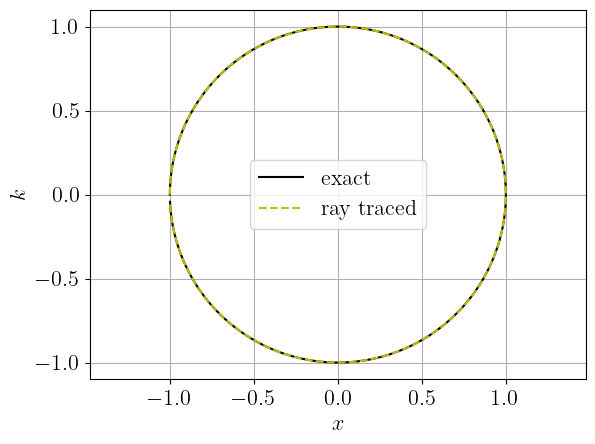

In [21]:
plt.axis('equal')
plt.plot(R*np.cos(2*t), -R*np.sin(2*t), 'k-', label='exact')
plt.plot(xs, ks, 'y--', label='ray traced')
plt.grid()
plt.xlabel(r'$x$')
plt.ylabel(r'$k$')
plt.legend()
plt.show()

### Apply MGO

In [22]:
i_save = np.arange(0, nt, int(nt/16))

In [23]:
def fit_amplitude(x, y):
    tmp_fit = fit_polynomial(x, y**(-4), deg=2, exclude_degrees=[1])
    return lambda eps: tmp_fit(eps)**(-1/4)

def fit_phase(x, y):
    nonlinear_func = FiniteDiffFunc1D(lambda eps: eps/2 * np.emath.sqrt(R**2 - eps**2) + R**2/2 * np.arcsin(eps/R))
    y_poly = y - nonlinear_func(x)
    polynomial = fit_polynomial(x, y_poly, deg=2, exclude_degrees=[0])
    return SumFunc([polynomial, nonlinear_func])

In [24]:
gauss_quad_order = 10
# branch_masks, ray_field, mgo_info = mgo.get_mgo_field(t, zs, phi0=1, i_save=i_save, 
#     analytic_cont={'phase': {'fit_func': fit_rational_func, 'kwargs': {'L': 6, 'M': 3, 'optimize': False}},
#                    'amplitude': {'fit_func': fit_amplitude, 'kwargs': {}}},
#     gauss_quad_order=gauss_quad_order)
branch_masks, ray_field, mgo_info = mgo.get_mgo_field(t, zs, phi0=1, i_save=i_save, 
    analytic_cont={'phase': {'fit_func': fit_phase, 'kwargs': {}},
                   'amplitude': {'fit_func': fit_amplitude, 'kwargs': {}}},
    gauss_quad_order=gauss_quad_order)
results = mgo_info['saved_results']
Nt = mgo_info['Nt']
Upsilon = mgo_info['Upsilon']

In [25]:
field = mgo.superpose_ray_fields(phi0=phi0, x0=x0, xs=xs, branch_masks=branch_masks, ray_field=ray_field)

### Inspect Results

#### Compare with Exact Solution

In [26]:
xs_ex = lambda t: R * np.cos(2*t)
ks_ex = lambda t: - R * np.sin(2*t)
A_ex = lambda t: -np.sin(2*t)
B_ex = lambda t: -np.cos(2*t)
B_phase = lambda t: np.pi * np.floor((4*t-np.pi)/(2*np.pi))
sigma_t_ex = lambda t: np.exp(-1j * np.pi * np.floor((4*t+np.pi)/(4*np.pi)))
Nt_ex = lambda t: (np.exp(1j*t*(R**2) - 1j * ((R**2)/4) * np.sin(4*t))
                    / (
                        np.emath.sqrt(-1j*2*np.pi*2*R)
                        * ut.continuous_sqrt_of_reals(B_ex(t))
                    ))

s = lambda t: -np.sign(np.tan(2*t))
Upsilon_ex = lambda t: ( np.pi * ((2*R)**(1/3))
                            * np.exp(-1j * (R**2)/3 * ((np.tan(2*t))**3) )
                            * (
                                Ai(-(np.tan(2*t)**2)/4 * ((2*R)**(4/3)))
                                + 1j * s(t) *
                                Bi(-(np.tan(2*t)**2)/4 * ((2*R)**(4/3)))
                            )
                            )

rho_ex = lambda x: (R**(2/3) * np.sqrt(R**2 - x**2)) / (2**(1/3) * x)
omega_bar_ex = lambda x: (x * np.sqrt(R**2-x**2) / 2
                          - R**2 * np.arccos(x/R)/2
                          + 2/3 * (rho_ex(x)**3)
                          + np.pi/4 * (1 - np.sign(x))
                          )
field_ex = lambda x: (Ai(-(rho_ex(x)**2)) * np.cos(omega_bar_ex(x)) / np.sqrt(np.abs(x))
                      - np.sign(x) * Bi(-rho_ex(x)**2) * np.sin(omega_bar_ex(x)) / np.sqrt(np.abs(x))
                      )

Phi_t1_ex = lambda eps: (1-(eps/R)**2)**(-1/4)
Theta_t1_ex = lambda eps: eps/2 * np.sqrt(R**2 - eps**2) + R**2/2 * np.arcsin(eps/R)
MT_phase_t1_ex = lambda eps, t: -R*eps - (eps**2) * np.tan(2*t)/2
f_t1_ex = lambda eps, t: Theta_t1_ex(eps) + MT_phase_t1_ex(eps, t)
ddf_ex = lambda eps, t: -eps**3/(2*(R**2 - eps**2)**(3/2)) - 3*eps/(2*np.sqrt(R**2 - eps**2)) - np.tan(2*t) + eps/(2*R*(1 - eps**2/R**2)**(3/2))

f_approx = lambda eps, t: -np.tan(2*t)/2 * (eps**2) - (eps**3/(6*R))
ddf_approx = lambda eps, t: -(np.tan(2*t) + eps/R)

/Users/rune.hoejlund/opt/anaconda3/envs/ray-tracer/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


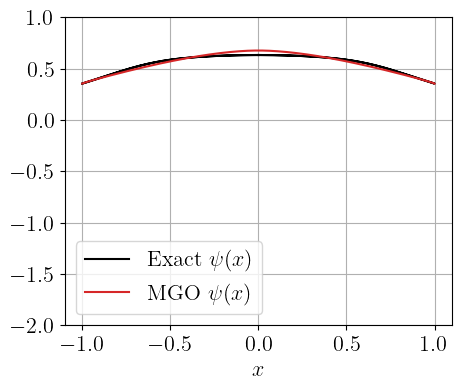

In [27]:
plt.figure(figsize=(5,4))
xi = np.linspace(np.min(xs), np.max(xs), 10000)
plt.plot(xs_ex(t), field_ex(xs_ex(t)), 'k-', label='Exact $\psi(x)$')
plt.plot(xi, field(xi), '-', color='tab:red', label='MGO $\psi(x)$')
plt.ylim(-2, 1)
plt.legend()
plt.xlabel(r'$x$')
plt.grid()
plt.savefig('./plots/MGO_weber_field_nu_' + str(nu) + '.png')
plt.savefig('./plots/MGO_weber_field_nu_' + str(nu) + '.pdf')
plt.show()

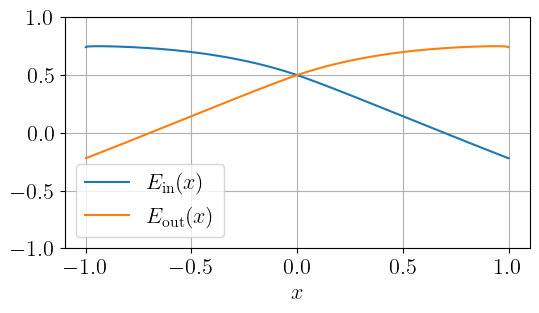

In [28]:
plt.figure(figsize=(6, 3))
plt.plot(xs[branch_masks[0], :], np.real(ray_field[branch_masks[0]]), '-', color='tab:blue', label='$E_\mathrm{in}(x)$')
plt.plot(xs[branch_masks[1], :], np.real(ray_field[branch_masks[1]]), '-', color='tab:orange', label='$E_\mathrm{out}(x)$')
plt.legend()
plt.ylim(-1, 1)
plt.xlabel(r'$x$')
plt.grid()
plt.show()

#### Upsilon Integrals - Comparison of Different Methods of Integration

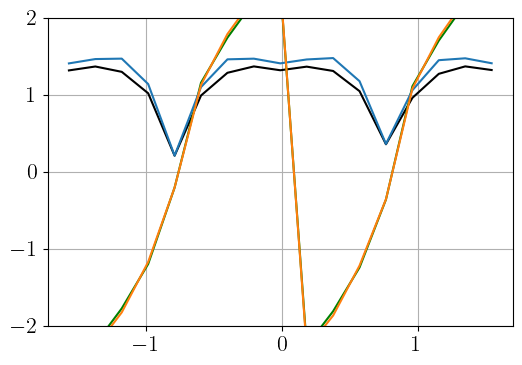

In [29]:
results_t = np.zeros(len(results))
results_xs = np.zeros(len(results))
results_it = np.zeros(len(results), dtype=int)
Upsilon_from_fit = np.zeros(len(results), dtype=np.cdouble)
Upsilon_from_ex = np.zeros(len(results), dtype=np.cdouble)
Upsilon_from_approx = np.zeros(len(results), dtype=np.cdouble)

l_ps = np.zeros(len(results))
l_ms = np.zeros(len(results))
s_ps = np.zeros(len(results))
s_ms = np.zeros(len(results))

for i, result in enumerate(results):
    t1, it, mask_t1, eps_rho, f_t1, f_fit, ddf_fit, g_fit, sigma_p, sigma_m, s_p, s_m, l_p, l_m = (result[key] for key in ['t1', 'it', 'mask_t1', 'eps_rho', 'f_t1', 'f_fit', 'ddf_fit', 'g_fit', 'sigma_p', 'sigma_m', 's_p', 's_m', 'l_p', 'l_m'])
    eps_rho = eps_rho.squeeze()
    results_t[i] = t[it]
    results_xs[i] = xs[it]
    results_it[i] = int(it)

    Upsilon_from_fit[i] = mgo.integrate_osc_func(f_fit, g_fit, sigma_p, sigma_m, s_p, s_m, gauss_quad_order=gauss_quad_order)
    # Plot node points along integral path
    if np.isclose(ddf_ex(0, t[it]), 0, atol=1e-1):
        sigma_p_ex, sigma_m_ex = mgo.new_angles(lambda eps: f_t1_ex(eps, t[it]), sigma_p_ex, sigma_m_ex, l_p[0], l_m[0])
    else:
        sigma_p_ex, sigma_m_ex = mgo.start_angles(lambda eps: ddf_ex(eps, t[it]))
    
    if np.isclose(ddf_approx(0, t[it]), 0, atol=1e-1):
        sigma_p_approx, sigma_m_approx = mgo.new_angles(lambda eps: f_approx(eps, t[it]), sigma_p_approx, sigma_m_approx, l_p[0], l_m[0])
    else:
        sigma_p_approx, sigma_m_approx = mgo.start_angles(lambda eps: ddf_approx(eps, t[it]))
    
    Upsilon_from_ex[i] = mgo.integrate_osc_func(lambda eps: f_t1_ex(eps, t[it]), Phi_t1_ex, np.array([sigma_p_ex]), np.array([sigma_m_ex]), s_p, s_m, gauss_quad_order=gauss_quad_order)

    Upsilon_from_approx[i] = mgo.integrate_osc_func(lambda eps: f_approx(eps, t[it]), lambda eps: Phi_t1_ex(0), np.array([sigma_p_approx]), np.array([sigma_m_approx]), np.array([0.1*1e2]), np.array([0.1*1e2]), gauss_quad_order=gauss_quad_order)

    l_ps[i] = l_p[0]
    l_ms[i] = l_m[0]
    s_ps[i] = s_p[0]
    s_ms[i] = s_m[0]

arg_sort_results = np.argsort(results_t)
results_t_sorted = results_t[arg_sort_results]
results_xs_sorted = results_xs[arg_sort_results]
results_it_sorted = results_it[arg_sort_results]
Upsilon_from_fit_sorted = Upsilon_from_fit[arg_sort_results]
Upsilon_from_ex_sorted = Upsilon_from_ex[arg_sort_results]
Upsilon_from_approx = Upsilon_from_approx[arg_sort_results]
Upsilon_num_sorted = Upsilon[results_it_sorted]
Upsilon_ex_sorted = Upsilon_ex(results_t_sorted)

l_ps_sorted = l_ps[arg_sort_results]
l_ms_sorted = l_ms[arg_sort_results]
s_ps_sorted = s_ps[arg_sort_results]
s_ms_sorted = s_ms[arg_sort_results]

plt.figure(figsize=(6, 4))
plt.plot(results_t_sorted, np.real(Upsilon_num_sorted), 'k-')
plt.plot(results_t_sorted, np.imag(Upsilon_num_sorted), 'g-')
# plt.plot(results_t_sorted, np.real(Upsilon_from_fit_sorted), 'y--')
# plt.plot(results_t_sorted, np.imag(Upsilon_from_fit_sorted), 'y--')
# plt.plot(results_t_sorted, np.real(Upsilon_from_ex_sorted), ':', color='tab:red')
# plt.plot(results_t_sorted, np.imag(Upsilon_from_ex_sorted), ':', color='tab:red')
# plt.plot(results_t_sorted, np.real(Upsilon_from_approx), '-', color='tab:purple')
# plt.plot(results_t_sorted, np.imag(Upsilon_from_approx), '-', color='tab:pink')
plt.plot(results_t_sorted, np.real(Upsilon_ex_sorted), '-', color='tab:blue')
plt.plot(results_t_sorted, np.imag(Upsilon_ex_sorted), '-', color='tab:orange')
plt.ylim(-2, 2)
plt.grid()
plt.show()

#### Analytic Continuation

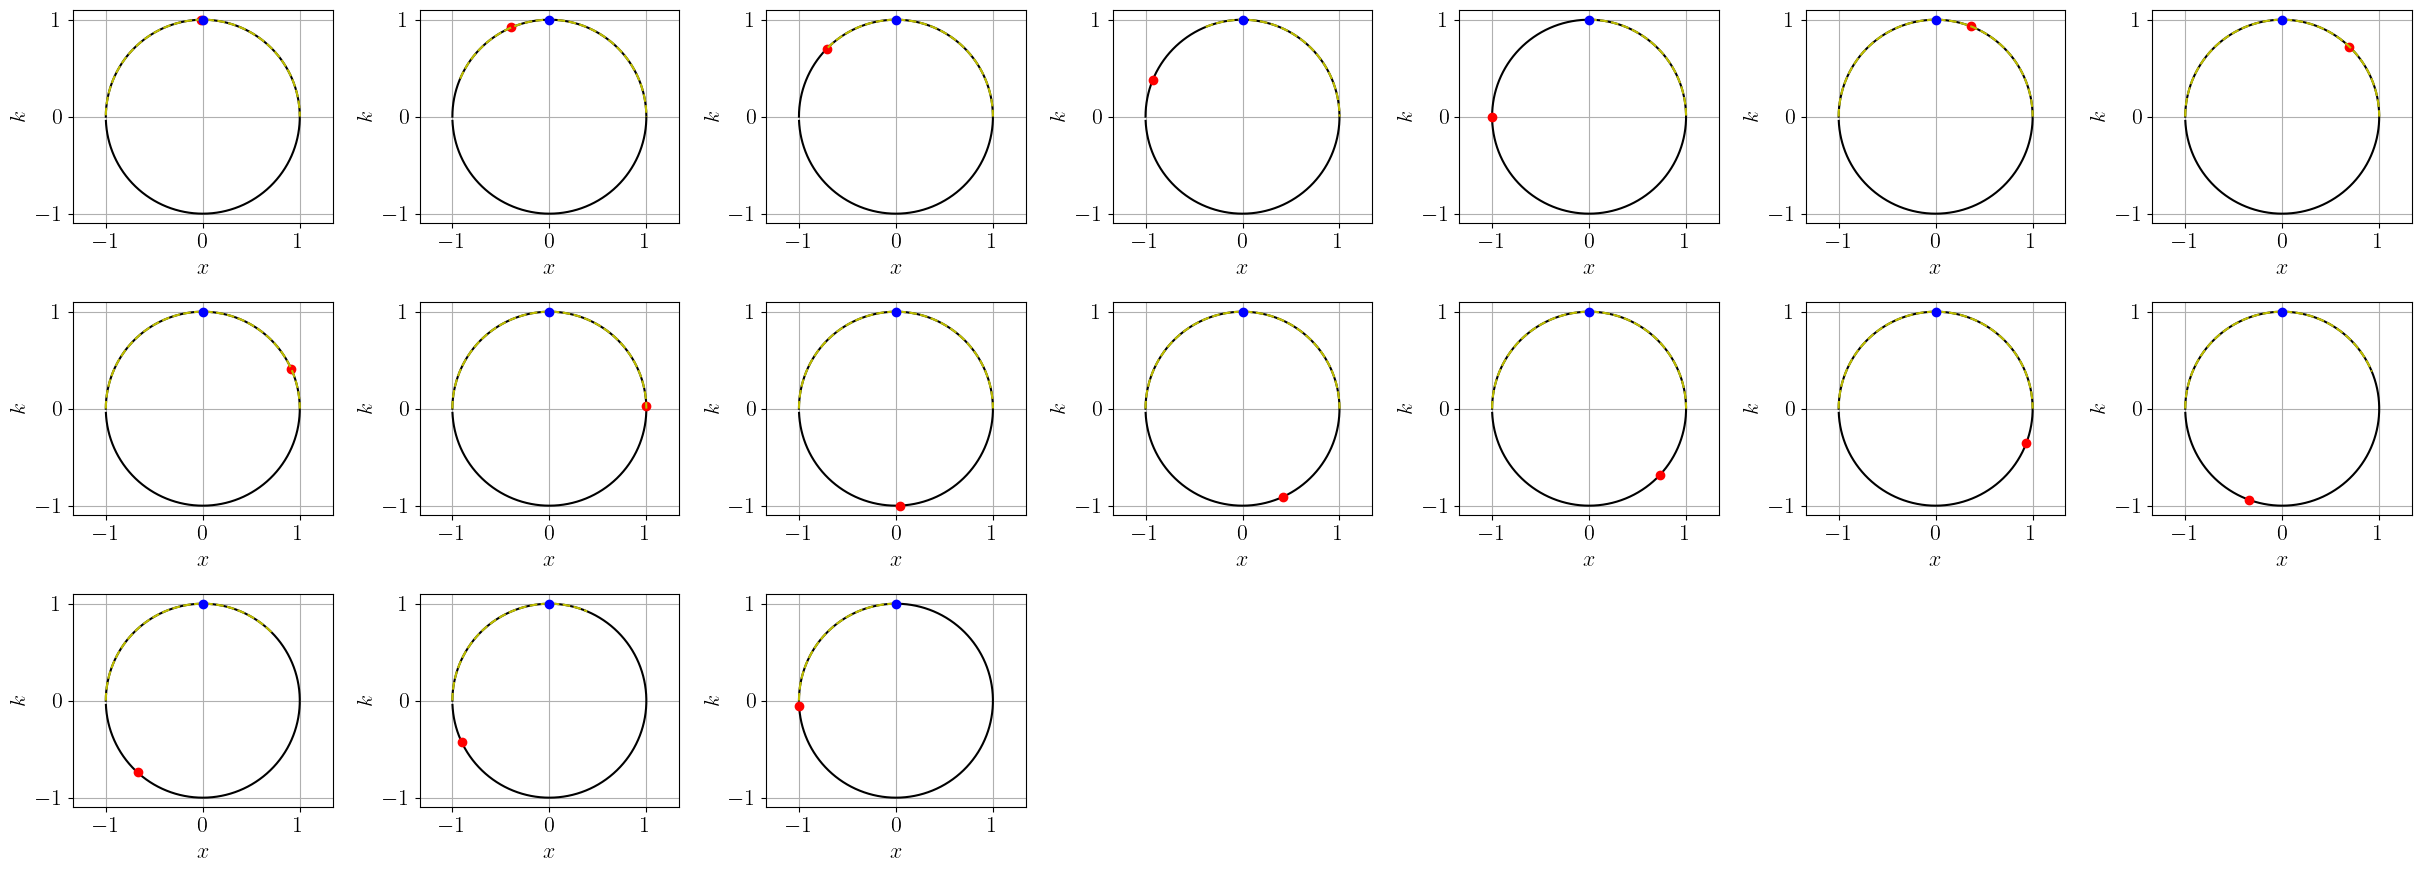

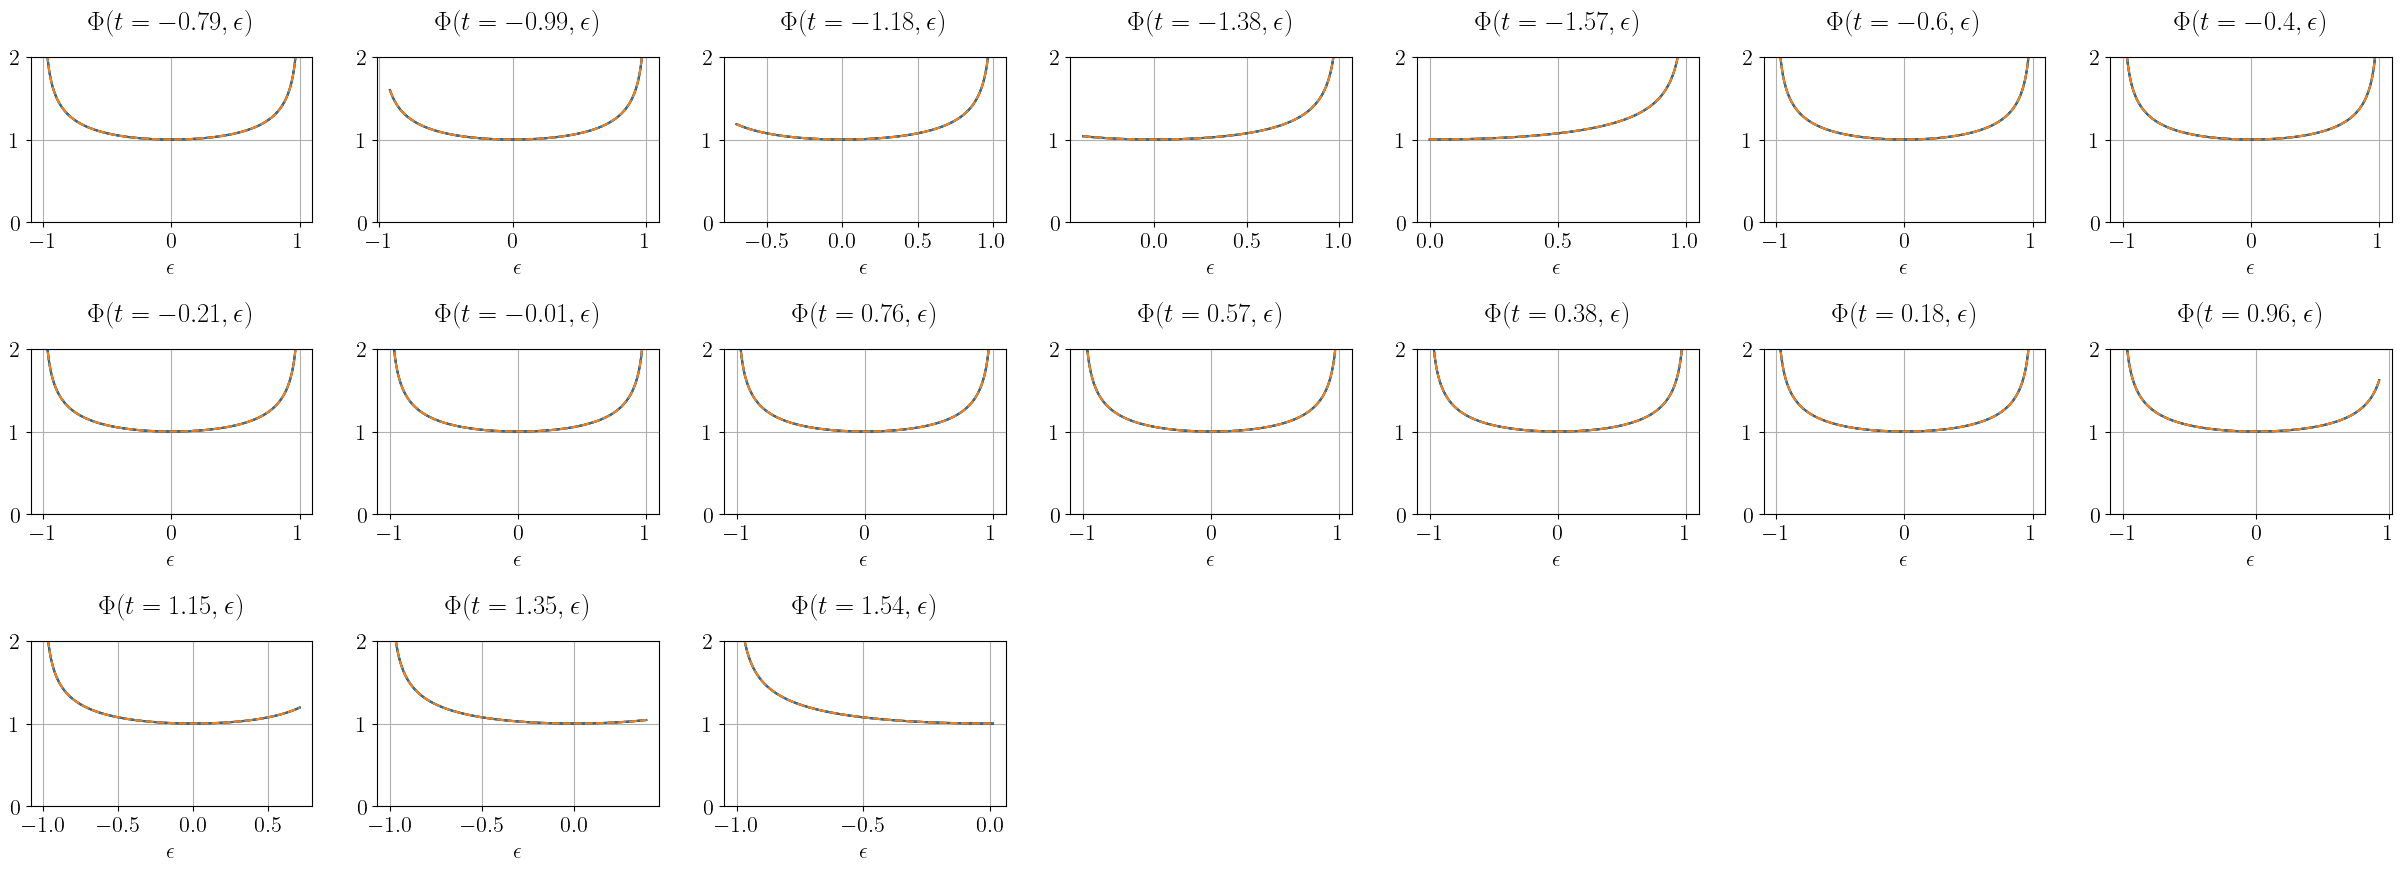

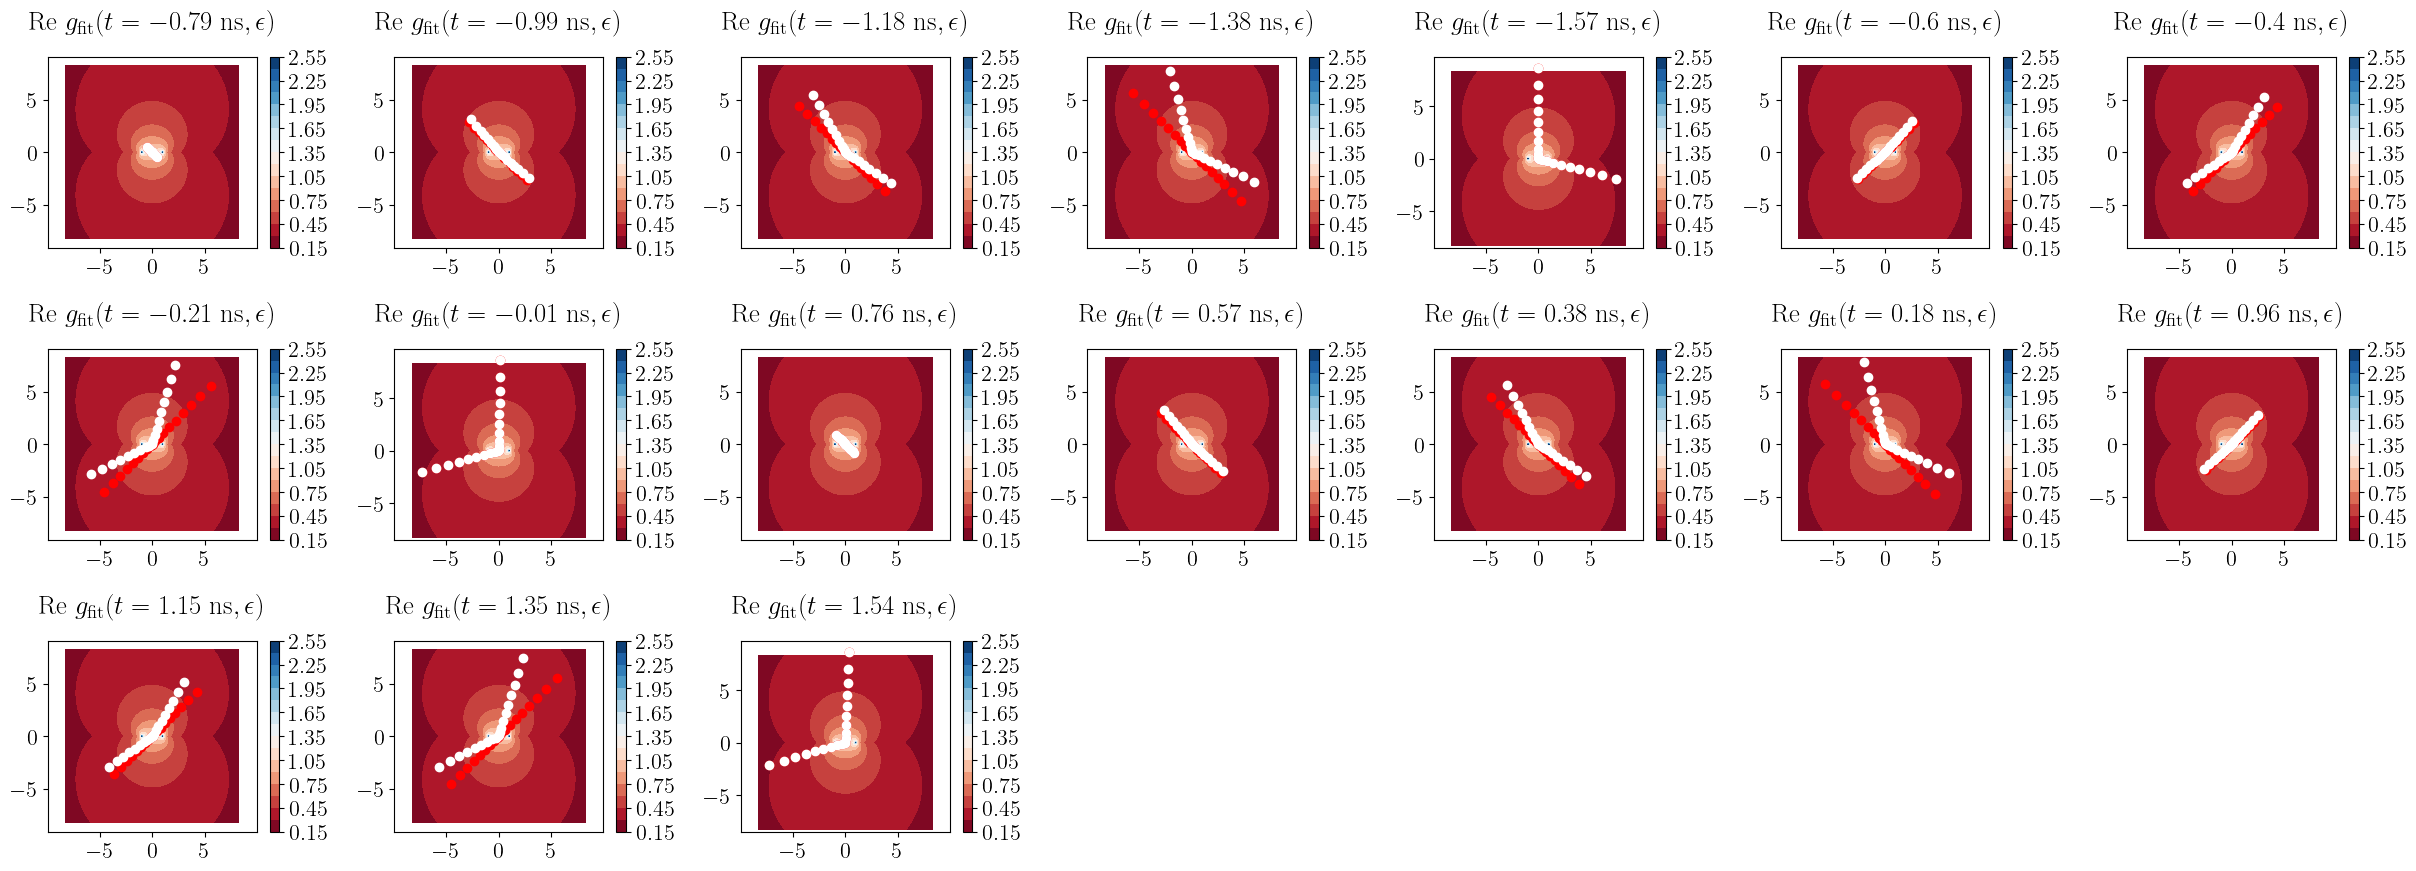

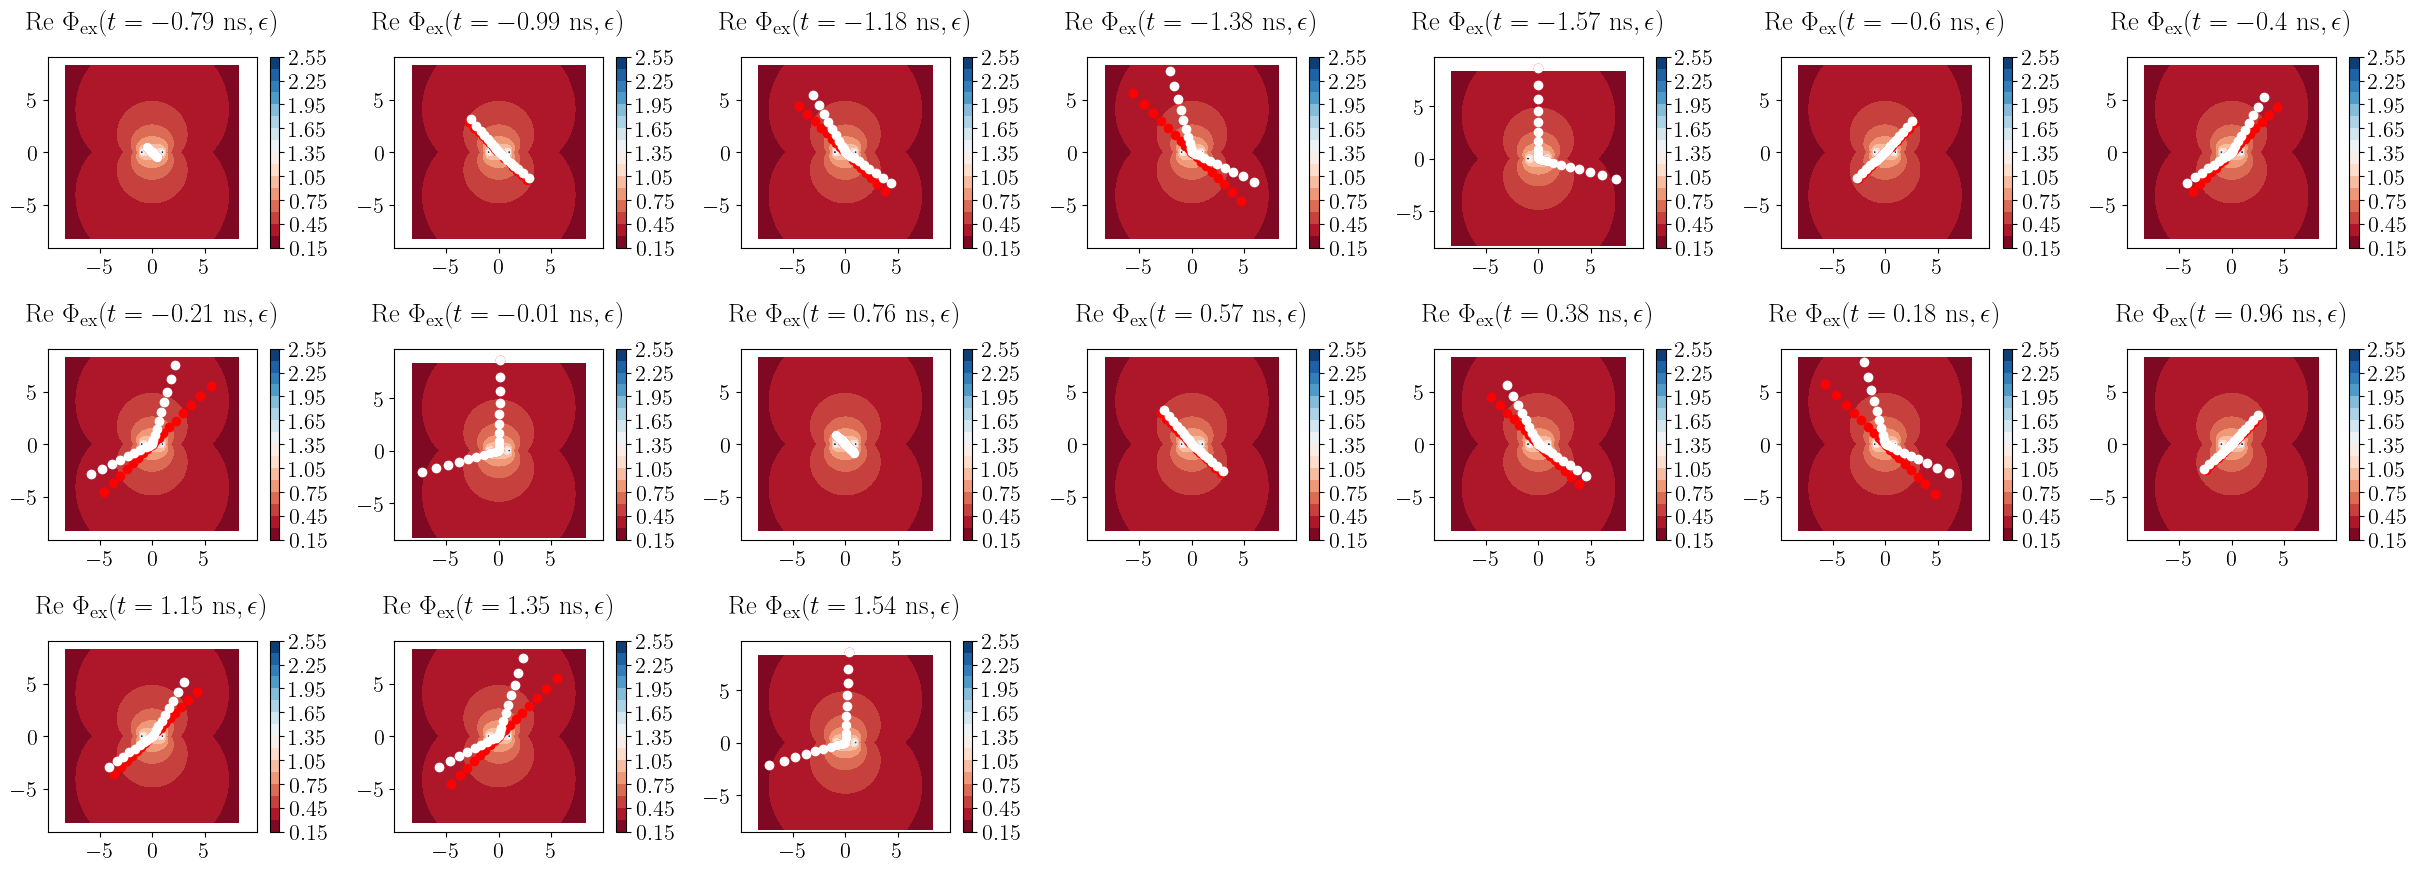

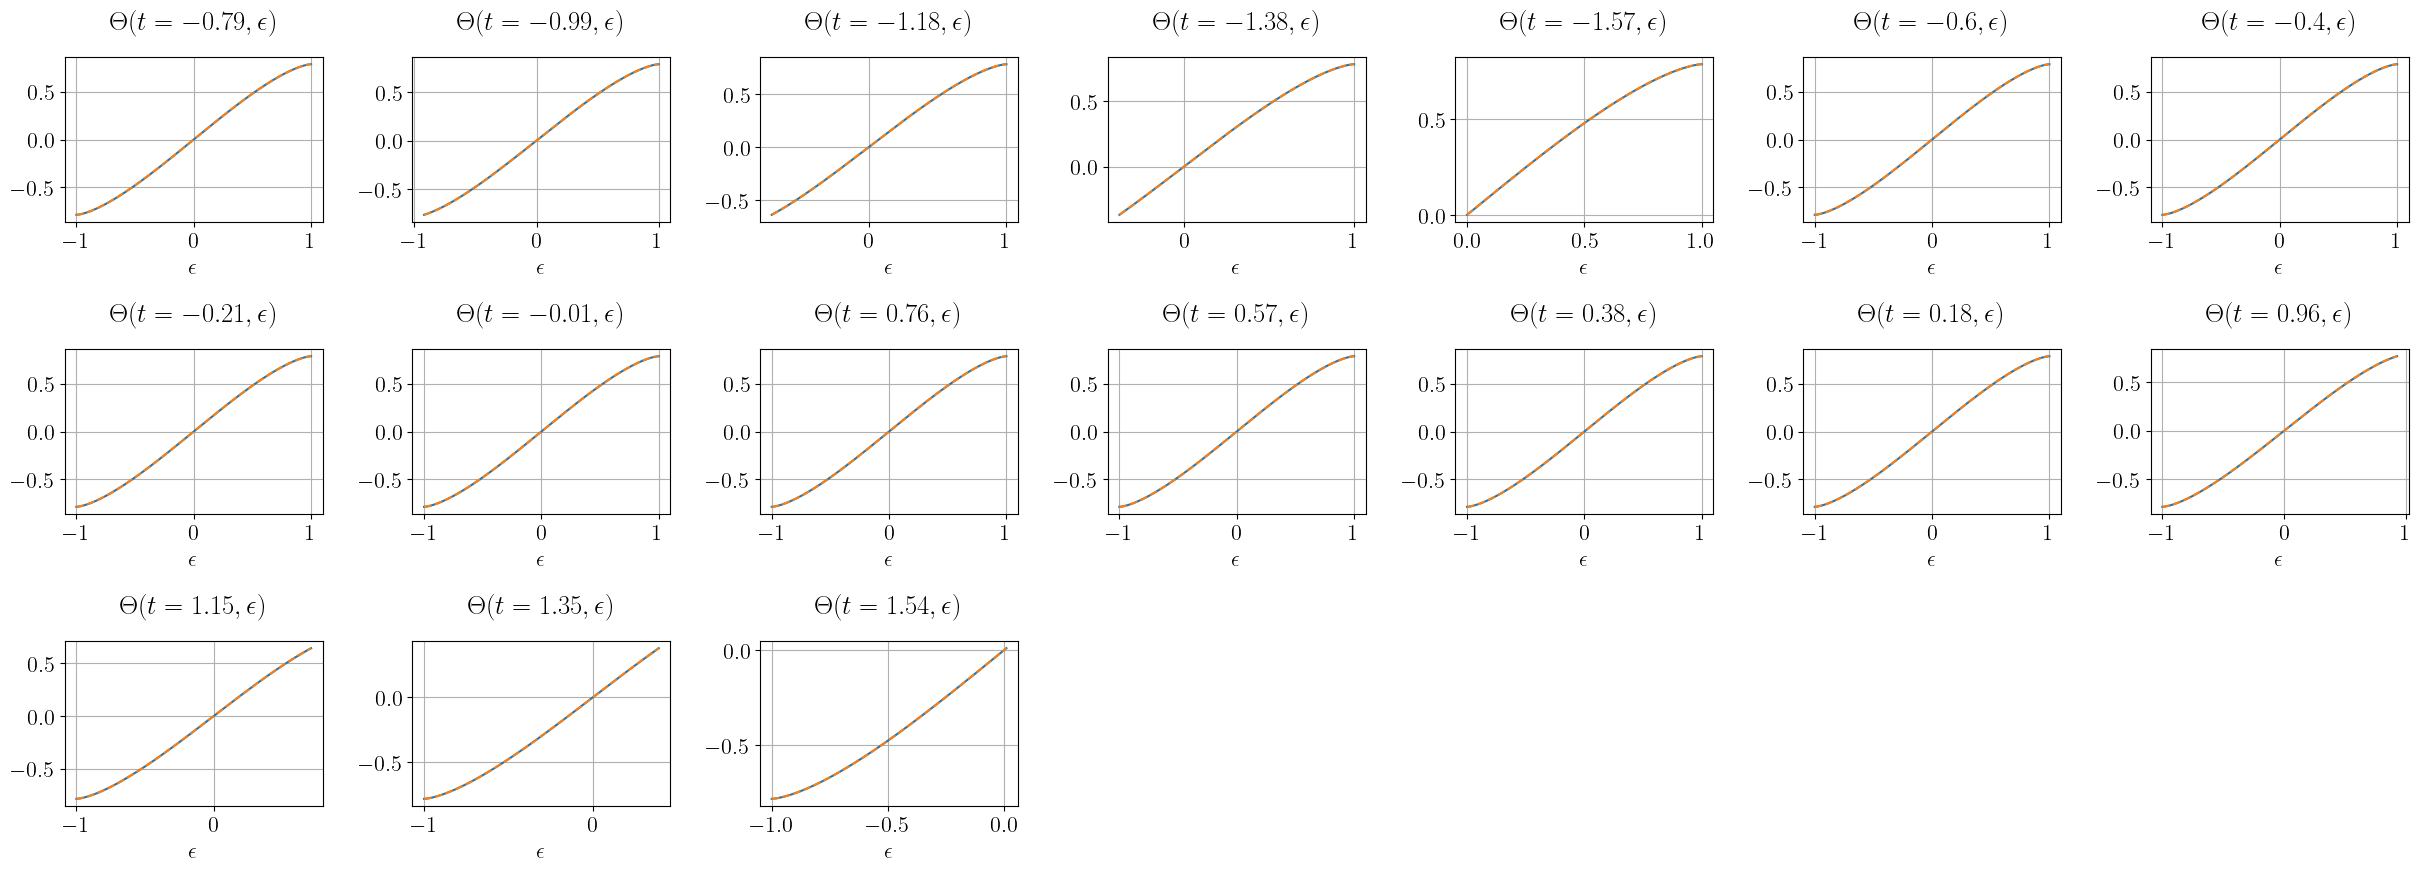

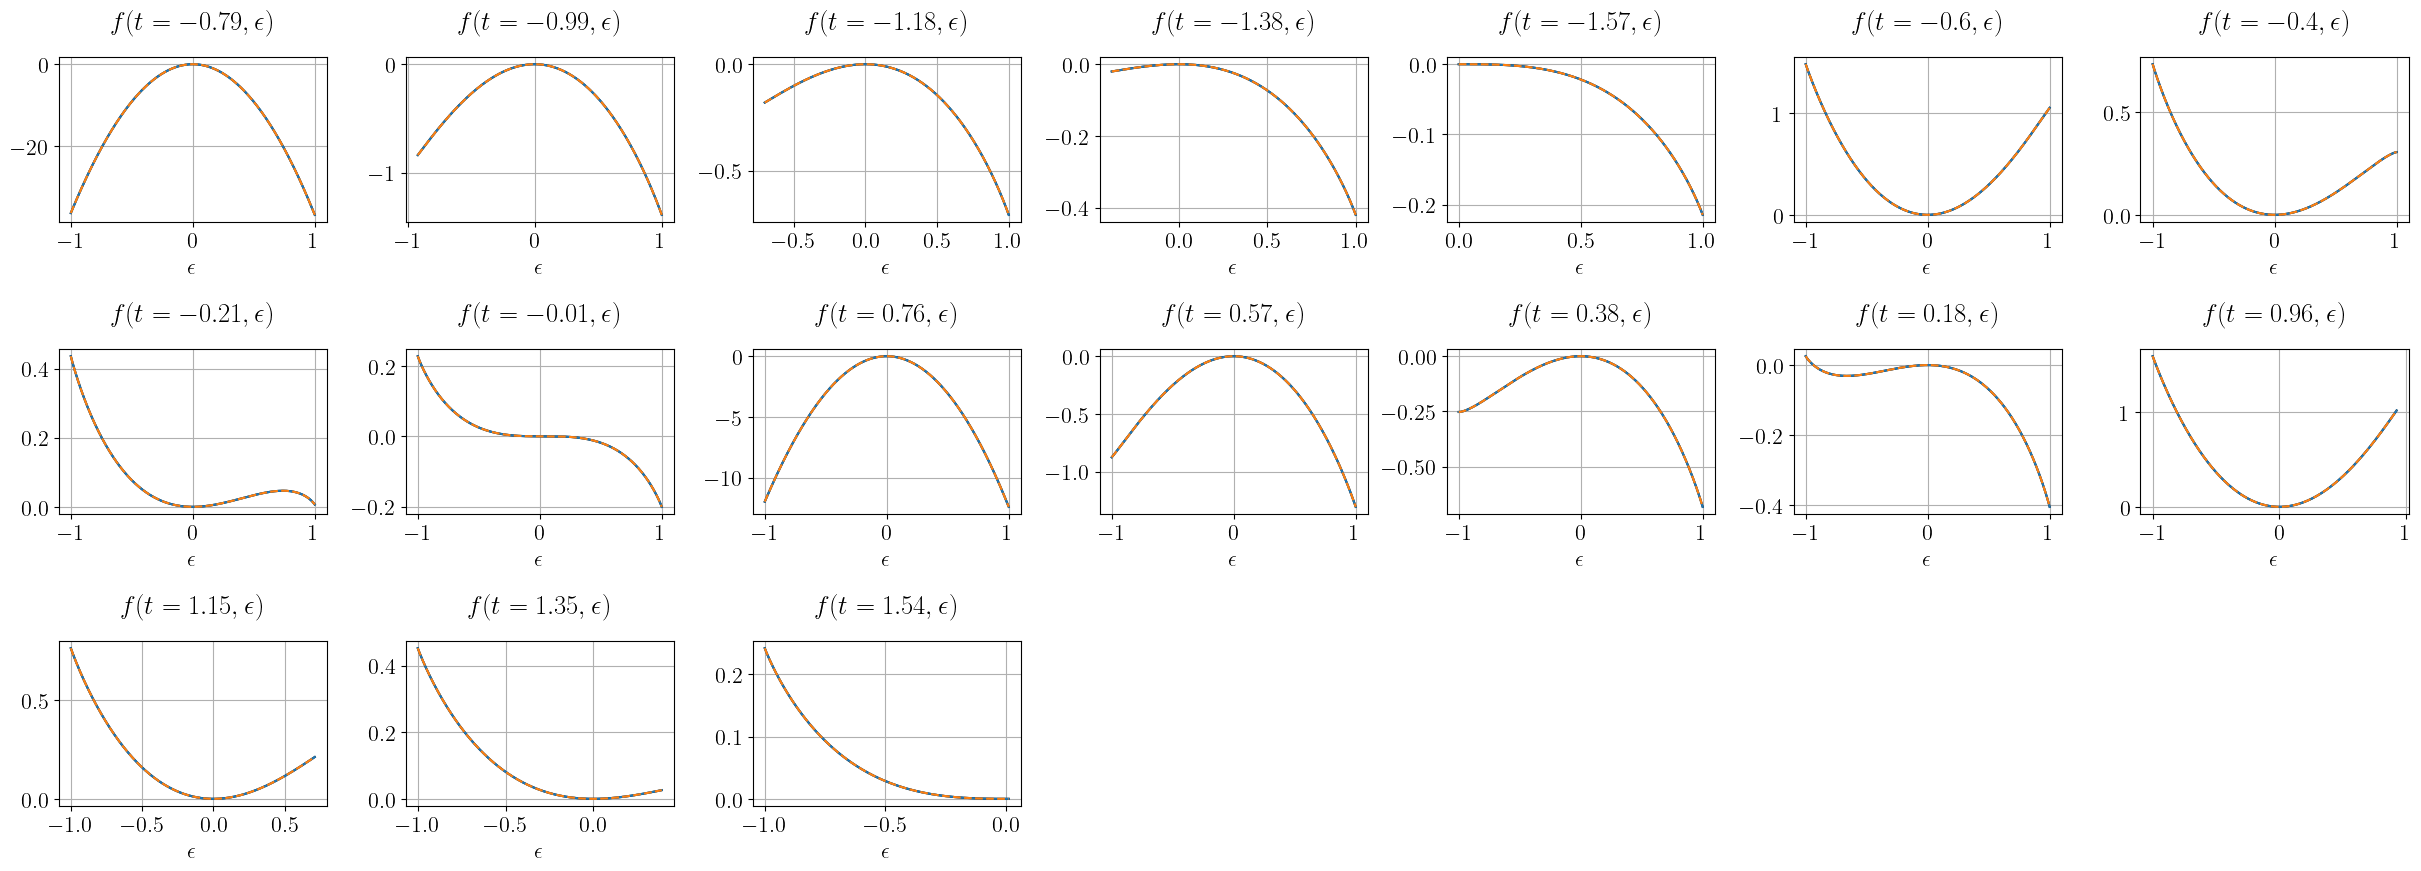

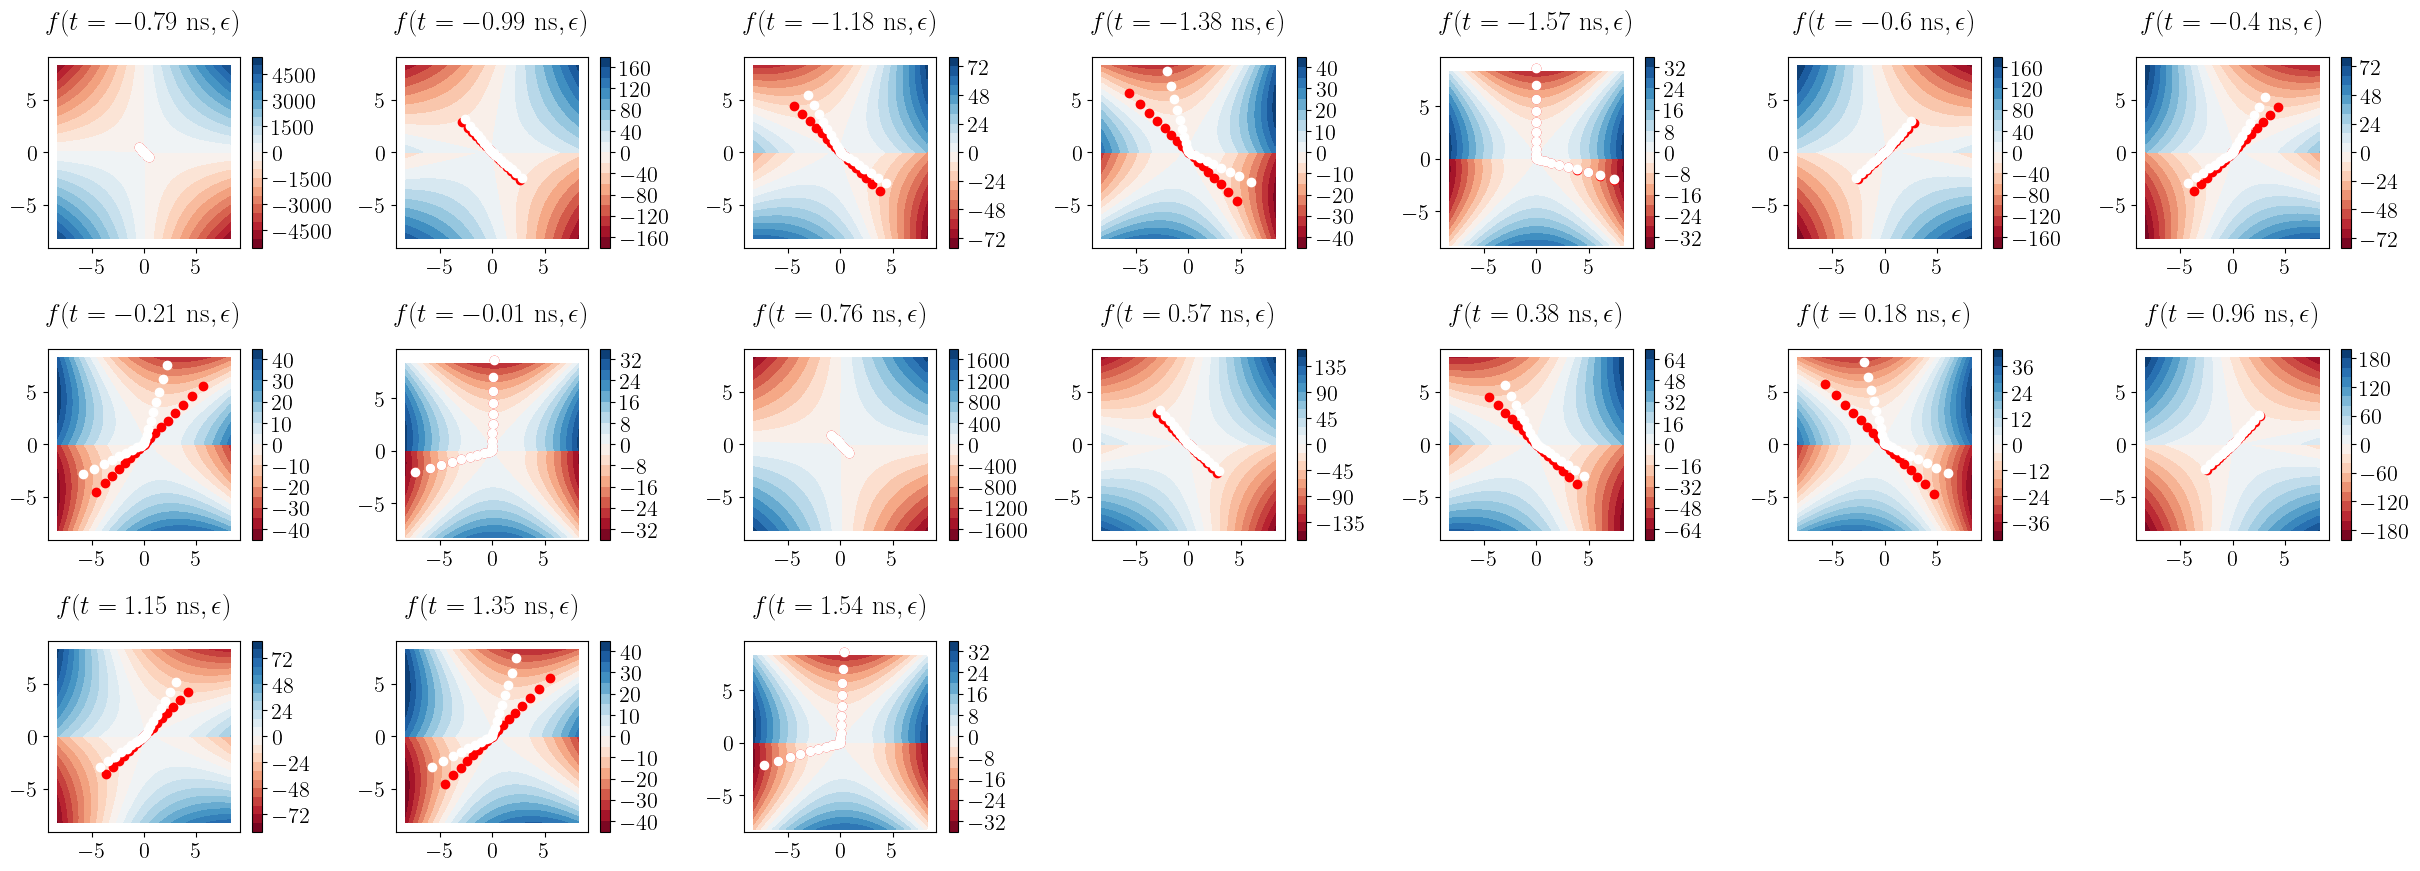

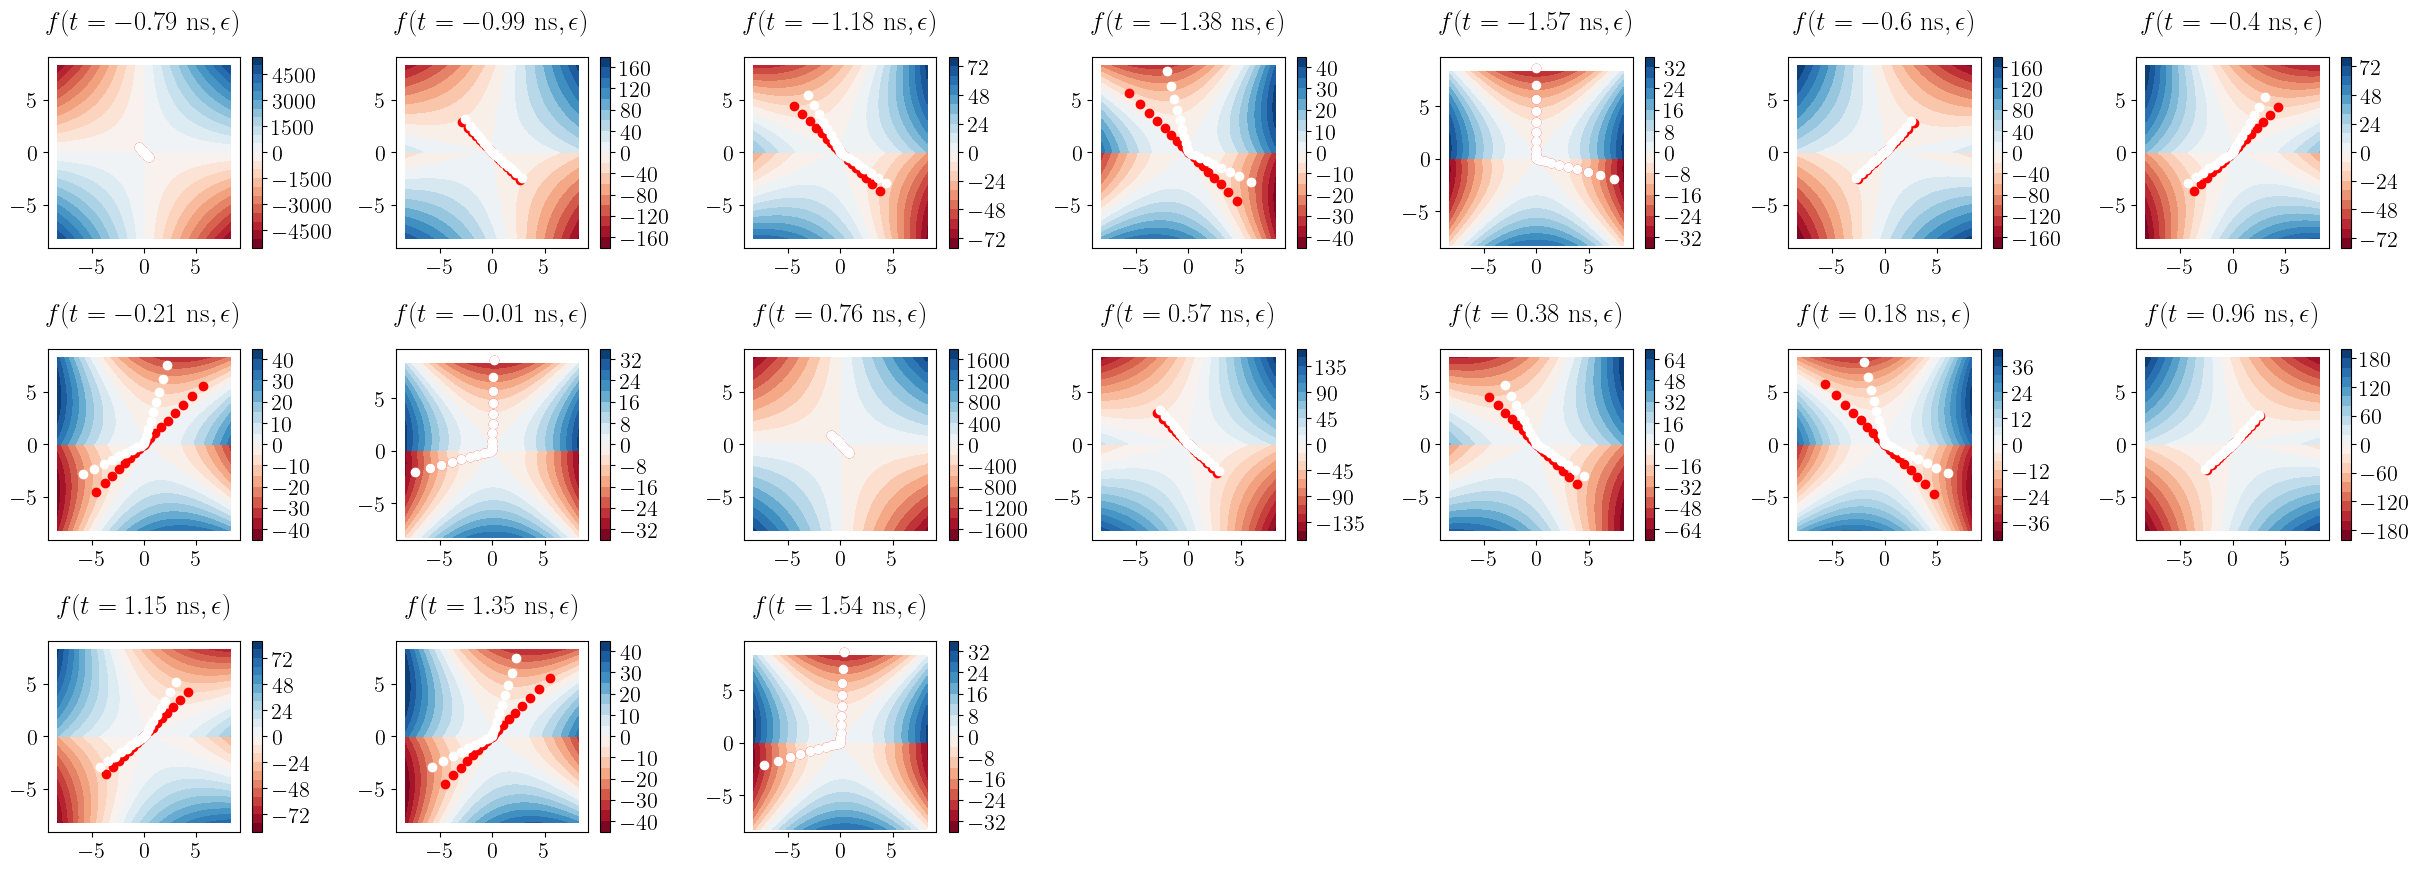

In [30]:
C = lambda l, sigma_p, sigma_m, s_p, s_m: np.abs(l) * np.piecewise(l, [l <= 0, l > 0], [lambda l: np.exp(1j*sigma_m)/np.emath.sqrt(s_m), lambda l: np.exp(1j*sigma_p)/np.emath.sqrt(s_p)])
C_R = lambda l, sigma_p, sigma_m, s_p, s_m: np.real(C(l, sigma_p, sigma_m, s_p, s_m))
C_I = lambda l, sigma_p, sigma_m, s_p, s_m: np.imag(C(l, sigma_p, sigma_m, s_p, s_m))

epsmax = np.mean([1/np.emath.sqrt(results[0]['s_m'][0]), 1/np.emath.sqrt(results[0]['s_p'][0])])
eps_R = np.linspace(-50*epsmax,50*epsmax, 1000)
eps_I = np.linspace(-50*epsmax,50*epsmax, 1000)
Eps_R, Eps_I = np.meshgrid(eps_R, eps_I)
Eps = Eps_R + 1j*Eps_I
l_j, _ = get_nodes_and_weights(n=10)
l_j = l_j.astype(np.complex_)

ncols, nrows = 7, 3
fig = plt.figure(1, figsize=(ncols*3.5,nrows*3))
fig2 = plt.figure(2, figsize=(ncols*3.5,nrows*3))
fig3 = plt.figure(3, figsize=(ncols*3.5,nrows*3))
fig4 = plt.figure(4, figsize=(ncols*3.5,nrows*3))
fig5 = plt.figure(5, figsize=(ncols*3.5,nrows*3))
fig6 = plt.figure(6, figsize=(ncols*3.5,nrows*3))
fig7 = plt.figure(7, figsize=(ncols*3.5,nrows*3))
fig8 = plt.figure(8, figsize=(ncols*3.5,nrows*3))

for i, result in enumerate(results):
    ax = fig.add_subplot(nrows, ncols, 1 + i)
    t1, it, it1, Xs_t1_all, Xs_t1, Ks_t1, mask_t1, eps_rho, f_t1, f_fit, ddf_fit, g_fit, sigma_p, sigma_m = (result[key] for key in ['t1', 'it', 'it1', 'Xs_t1_all', 'Xs_t1', 'Ks_t1', 'mask_t1', 'eps_rho', 'f_t1', 'f_fit', 'ddf_fit', 'g_fit', 'sigma_p', 'sigma_m'])
    ax.axis('equal')
    ax.plot(xs.squeeze(), ks.squeeze(), 'k-')
    ax.plot(xs[it], ks[it], 'ro')
    ax.plot(Xs_t1.squeeze(), Ks_t1.squeeze(), 'y--')
    ax.plot(Xs_t1[it1], Ks_t1[it1], 'bo')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$k$')
    ax.grid()
fig.tight_layout()


for i, result in enumerate(results):
    ax = fig2.add_subplot(nrows, ncols, 1 + i)
    t1, it, mask_t1, eps_rho, f_t1, Phi_t1, f_fit, ddf_fit, g_fit, sigma_p, sigma_m = (result[key] for key in ['t1', 'it', 'mask_t1', 'eps_rho', 'f_t1', 'Phi_t1', 'f_fit', 'ddf_fit', 'g_fit', 'sigma_p', 'sigma_m'])
    eps_rho = eps_rho.squeeze()
    ax.plot(eps_rho, Phi_t1, 'k-')
    ax.plot(eps_rho, Phi_t1_ex(eps_rho), '-', color='tab:blue')
    ax.plot(eps_rho, g_fit(eps_rho), '--', color='tab:orange')
    ax.set_ylim(0, 2)
    ax.set_title(r'$\Phi(t = ' + str(np.round(t1, 2)) + r', \epsilon)$')
    ax.set_xlabel(r'$\epsilon$')
    ax.grid()
fig2.tight_layout()

for i, result in enumerate(results):
    ax = fig3.add_subplot(nrows, ncols, 1 + i)
    ax.axis('equal')
    t1, it, mask_t1, eps_rho, f_t1, f_fit, ddf_fit, g_fit, sigma_p, sigma_m, s_p, s_m, l_p, l_m = (result[key] for key in ['t1', 'it', 'mask_t1', 'eps_rho', 'f_t1', 'f_fit', 'ddf_fit', 'g_fit', 'sigma_p', 'sigma_m', 's_p', 's_m', 'l_p', 'l_m'])
    eps_rho = eps_rho.squeeze()
    contour_plot = ax.contourf(Eps_R, Eps_I, np.real(g_fit(Eps.reshape(-1, 1)).reshape(Eps.shape)), cmap='RdBu', levels=20)
    fig.colorbar(contour_plot, ax=ax)
    ax.set_title(r'Re $g_\mathrm{fit}(t = ' + str(np.round(t1,2)) + r'$ ns$, \epsilon)$')
    # ax.set_xlabel(r'$\mathrm{Re}(\epsilon)$')
    # ax.set_ylabel(r'$\mathrm{Im}(\epsilon)$')

    # Plot node points along integral path
    if np.isclose(ddf_ex(0, t[it]), 0, atol=1e-1):
        sigma_p_ex, sigma_m_ex = mgo.new_angles(lambda eps: f_t1_ex(eps, t[it]), sigma_p_ex, sigma_m_ex, l_p[0], l_m[0])
    else:
        sigma_p_ex, sigma_m_ex = mgo.start_angles(lambda eps: ddf_ex(eps, t[it]))
    ax.plot(C_R(-l_j, sigma_p_ex, sigma_m_ex, s_p[0], s_m[0]), C_I(-l_j, sigma_p_ex, sigma_m_ex, s_p[0], s_m[0]), 'or')
    ax.plot(C_R(l_j, sigma_p_ex, sigma_m_ex, s_p[0], s_m[0]), C_I(l_j, sigma_p_ex, sigma_m_ex, s_p[0], s_m[0]), 'or')
    
    ax.plot(C_R(-l_j, sigma_p[0], sigma_m[0], s_p[0], s_m[0]), C_I(-l_j, sigma_p[0], sigma_m[0], s_p[0], s_m[0]), 'ow')
    ax.plot(C_R(l_j, sigma_p[0], sigma_m[0], s_p[0], s_m[0]), C_I(l_j, sigma_p[0], sigma_m[0], s_p[0], s_m[0]), 'ow')
fig3.tight_layout()

for i, result in enumerate(results):
    ax = fig4.add_subplot(nrows, ncols, 1 + i)
    ax.axis('equal')
    t1, it, mask_t1, eps_rho, f_t1, f_fit, ddf_fit, g_fit, sigma_p, sigma_m, s_p, s_m, l_p, l_m = (result[key] for key in ['t1', 'it', 'mask_t1', 'eps_rho', 'f_t1', 'f_fit', 'ddf_fit', 'g_fit', 'sigma_p', 'sigma_m', 's_p', 's_m', 'l_p', 'l_m'])
    eps_rho = eps_rho.squeeze()
    contour_plot = ax.contourf(Eps_R, Eps_I, np.real(Phi_t1_ex(Eps.reshape(-1, 1)).reshape(Eps.shape)), cmap='RdBu', levels=20)
    fig.colorbar(contour_plot, ax=ax)
    ax.set_title(r'Re $\Phi_\mathrm{ex}(t = ' + str(np.round(t1,2)) + r'$ ns$, \epsilon)$')
    # ax.set_xlabel(r'$\mathrm{Re}(\epsilon)$')
    # ax.set_ylabel(r'$\mathrm{Im}(\epsilon)$')

    # Plot node points along integral path
    if np.isclose(ddf_ex(0, t[it]), 0, atol=1e-1):
        sigma_p_ex, sigma_m_ex = mgo.new_angles(lambda eps: f_t1_ex(eps, t[it]), sigma_p_ex, sigma_m_ex, l_p[0], l_m[0])
    else:
        sigma_p_ex, sigma_m_ex = mgo.start_angles(lambda eps: ddf_ex(eps, t[it]))
    ax.plot(C_R(-l_j, sigma_p_ex, sigma_m_ex, s_p[0], s_m[0]), C_I(-l_j, sigma_p_ex, sigma_m_ex, s_p[0], s_m[0]), 'or')
    ax.plot(C_R(l_j, sigma_p_ex, sigma_m_ex, s_p[0], s_m[0]), C_I(l_j, sigma_p_ex, sigma_m_ex, s_p[0], s_m[0]), 'or')
    
    ax.plot(C_R(-l_j, sigma_p[0], sigma_m[0], s_p[0], s_m[0]), C_I(-l_j, sigma_p[0], sigma_m[0], s_p[0], s_m[0]), 'ow')
    ax.plot(C_R(l_j, sigma_p[0], sigma_m[0], s_p[0], s_m[0]), C_I(l_j, sigma_p[0], sigma_m[0], s_p[0], s_m[0]), 'ow')
fig4.tight_layout()


for i, result in enumerate(results):
    ax = fig5.add_subplot(nrows, ncols, 1 + i)
    t1, it, mask_t1, eps_rho, Theta_t1, f_t1, Phi_t1, f_fit, ddf_fit, g_fit, sigma_p, sigma_m = (result[key] for key in ['t1', 'it', 'mask_t1', 'eps_rho', 'Theta_t1', 'f_t1', 'Phi_t1', 'f_fit', 'ddf_fit', 'g_fit', 'sigma_p', 'sigma_m'])
    eps_rho = eps_rho.squeeze()
    ax.plot(eps_rho, Theta_t1_ex(eps_rho), '-', color='tab:blue')
    ax.plot(eps_rho, Theta_t1, '--', color='tab:orange')
    ax.set_title(r'$\Theta(t = ' + str(np.round(t1, 2)) + r', \epsilon)$')
    ax.set_xlabel(r'$\epsilon$')
    ax.grid()
fig5.tight_layout()

for i, result in enumerate(results):
    ax = fig6.add_subplot(nrows, ncols, 1 + i)
    t1, it, mask_t1, eps_rho, f_t1, f_fit, ddf_fit, g_fit, sigma_p, sigma_m = (result[key] for key in ['t1', 'it', 'mask_t1', 'eps_rho', 'f_t1', 'f_fit', 'ddf_fit', 'g_fit', 'sigma_p', 'sigma_m'])
    k = ks[it, 0]
    eps_rho = eps_rho.squeeze()
    ax.plot(eps_rho, f_t1, 'k-')
    ax.plot(eps_rho, f_t1_ex(eps_rho, t[it]), '-', color='tab:blue')
    ax.plot(eps_rho, f_fit(eps_rho), '--', color='tab:orange')
    ax.set_title(r'$f(t = ' + str(np.round(t1,2)) + r', \epsilon)$')
    ax.set_xlabel(r'$\epsilon$')
    ax.grid()
fig6.tight_layout()

for i, result in enumerate(results):
    ax = fig7.add_subplot(nrows, ncols, 1 + i)
    ax.axis('equal')
    t1, it, mask_t1, eps_rho, f_t1, f_fit, ddf_fit, g_fit, sigma_p, sigma_m, s_p, s_m = (result[key] for key in ['t1', 'it', 'mask_t1', 'eps_rho', 'f_t1', 'f_fit', 'ddf_fit', 'g_fit', 'sigma_p', 'sigma_m', 's_p', 's_m'])
    eps_rho = eps_rho.squeeze()
    contour_plot = ax.contourf(Eps_R, Eps_I, -np.imag(f_fit(Eps.reshape(-1, 1)).reshape(Eps.shape)), cmap='RdBu', levels=20)
    fig.colorbar(contour_plot, ax=ax)
    ax.set_title(r'$f(t = ' + str(np.round(t1,2)) + r'$ ns$, \epsilon)$')
    # ax.set_xlabel(r'$\mathrm{Re}(\epsilon)$')
    # ax.set_ylabel(r'$\mathrm{Im}(\epsilon)$')

    # Plot node points along integral path
    if np.isclose(ddf_ex(0, t[it]), 0, atol=1e-1):
        sigma_p_ex, sigma_m_ex = mgo.new_angles(lambda eps: f_t1_ex(eps, t[it]), sigma_p_ex, sigma_m_ex, l_p[0], l_m[0])
    else:
        sigma_p_ex, sigma_m_ex = mgo.start_angles(lambda eps: ddf_ex(eps, t[it]))
    ax.plot(C_R(-l_j, sigma_p_ex, sigma_m_ex, s_p[0], s_m[0]), C_I(-l_j, sigma_p_ex, sigma_m_ex, s_p[0], s_m[0]), 'or')
    ax.plot(C_R(l_j, sigma_p_ex, sigma_m_ex, s_p[0], s_m[0]), C_I(l_j, sigma_p_ex, sigma_m_ex, s_p[0], s_m[0]), 'or')
    
    ax.plot(C_R(-l_j, sigma_p[0], sigma_m[0], s_p[0], s_m[0]), C_I(-l_j, sigma_p[0], sigma_m[0], s_p[0], s_m[0]), 'ow')
    ax.plot(C_R(l_j, sigma_p[0], sigma_m[0], s_p[0], s_m[0]), C_I(l_j, sigma_p[0], sigma_m[0], s_p[0], s_m[0]), 'ow')
fig7.tight_layout()

for i, result in enumerate(results):
    ax = fig8.add_subplot(nrows, ncols, 1 + i)
    ax.axis('equal')
    t1, it, mask_t1, eps_rho, f_t1, f_fit, ddf_fit, g_fit, sigma_p, sigma_m, s_p, s_m, l_p, l_m = (result[key] for key in ['t1', 'it', 'mask_t1', 'eps_rho', 'f_t1', 'f_fit', 'ddf_fit', 'g_fit', 'sigma_p', 'sigma_m', 's_p', 's_m', 'l_p', 'l_m'])
    eps_rho = eps_rho.squeeze()
    contour_plot = ax.contourf(Eps_R, Eps_I, -np.imag(f_t1_ex(Eps.reshape(-1, 1), t[it]).reshape(Eps.shape)), cmap='RdBu', levels=20)
    fig.colorbar(contour_plot, ax=ax)
    ax.set_title(r'$f(t = ' + str(np.round(t1,2)) + r'$ ns$, \epsilon)$')
    # ax.set_xlabel(r'$\mathrm{Re}(\epsilon)$')
    # ax.set_ylabel(r'$\mathrm{Im}(\epsilon)$')

    # Plot node points along integral path
    if np.isclose(ddf_ex(0, t[it]), 0, atol=1e-1):
        sigma_p_ex, sigma_m_ex = mgo.new_angles(lambda eps: f_t1_ex(eps, t[it]), sigma_p_ex, sigma_m_ex, l_p[0], l_m[0])
    else:
        sigma_p_ex, sigma_m_ex = mgo.start_angles(lambda eps: ddf_ex(eps, t[it]))
    ax.plot(C_R(-l_j, sigma_p_ex, sigma_m_ex, s_p[0], s_m[0]), C_I(-l_j, sigma_p_ex, sigma_m_ex, s_p[0], s_m[0]), 'or')
    ax.plot(C_R(l_j, sigma_p_ex, sigma_m_ex, s_p[0], s_m[0]), C_I(l_j, sigma_p_ex, sigma_m_ex, s_p[0], s_m[0]), 'or')
    ax.plot(C_R(-l_j, sigma_p[0], sigma_m[0], s_p[0], s_m[0]), C_I(-l_j, sigma_p[0], sigma_m[0], s_p[0], s_m[0]), 'ow')
    ax.plot(C_R(l_j, sigma_p[0], sigma_m[0], s_p[0], s_m[0]), C_I(l_j, sigma_p[0], sigma_m[0], s_p[0], s_m[0]), 'ow')
fig8.tight_layout()

plt.show()

#### Comparison of $\mathcal{N}_t$ and $\Upsilon_t$

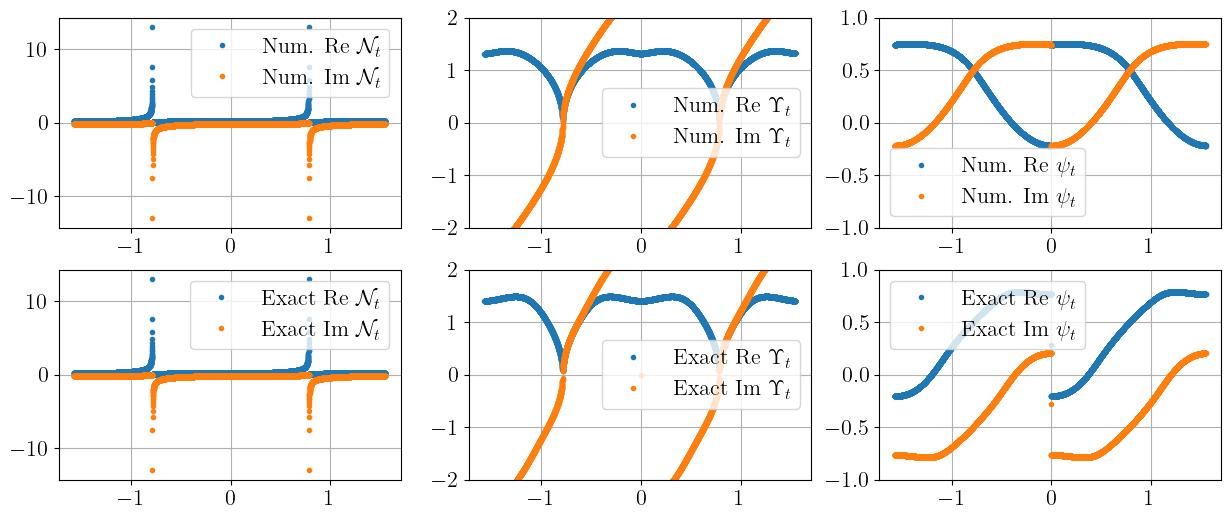

In [31]:
phi0 = field_ex(xs_ex(t))[0]
# A0_num = phi0/(Nt[0]*Upsilon[0] + Nt[-1]*Upsilon[-1] )
# A0 = phi0/(Nt_ex(t_ex)[0]*Upsilon_ex(t_ex)[0] + Nt_ex(t_ex)[-1]*Upsilon_ex(t_ex)[-1] )

fig, ax = plt.subplots(2, 3, figsize=(15, 6))

ax[0, 0].plot(t, np.real(Nt_ex(t)[0]/Nt[0] * Nt), '.', label=r'Num. Re $\mathcal{N}_t$')
ax[0, 0].plot(t, np.imag(Nt_ex(t)[0]/Nt[0] * Nt), '.', label=r'Num. Im $\mathcal{N}_t$')
ax[0, 0].legend()
ax[0, 0].grid()
# ax[0, 0].set_ylim(-5,5)

ax[0, 1].plot(t, np.real(Upsilon), '.', label=r'Num. Re $\Upsilon_t$')
ax[0, 1].plot(t, np.imag(Upsilon), '.', label=r'Num. Im $\Upsilon_t$')
ax[0, 1].legend()
ax[0, 1].grid()
ax[0, 1].set_ylim(-2, 2)

ax[0, 2].plot(t, np.real(Nt*Upsilon), '.', label=r'Num. Re $\psi_t$')
ax[0, 2].plot(t, np.imag(Nt*Upsilon), '.', label=r'Num. Im $\psi_t$')
ax[0, 2].legend()
ax[0, 2].grid()
ax[0, 2].set_ylim(-1,1)

ax[1, 0].plot(t, np.real(Nt_ex(t)), '.', label=r'Exact Re $\mathcal{N}_t$')
ax[1, 0].plot(t, np.imag(Nt_ex(t)), '.', label=r'Exact Im $\mathcal{N}_t$')
ax[1, 0].legend()
ax[1, 0].grid()
# ax[1, 0].set_ylim(-5,5)

ax[1, 1].plot(t, np.real(Upsilon_ex(t)), '.', label=r'Exact Re $\Upsilon_t$')
ax[1, 1].plot(t, np.imag(Upsilon_ex(t)), '.', label=r'Exact Im $\Upsilon_t$')
ax[1, 1].legend()
ax[1, 1].grid()
ax[1, 1].set_ylim(-2, 2)

ax[1, 2].plot(t, np.real(Nt_ex(t)*Upsilon_ex(t)), '.', label=r'Exact Re $\psi_t$')
ax[1, 2].plot(t, np.imag(Nt_ex(t)*Upsilon_ex(t)), '.', label=r'Exact Im $\psi_t$')
ax[1, 2].legend()
ax[1, 2].grid()
ax[1, 2].set_ylim(-1,1)

plt.show()

#### Inspection $\mathcal{N}_t$ Calculation

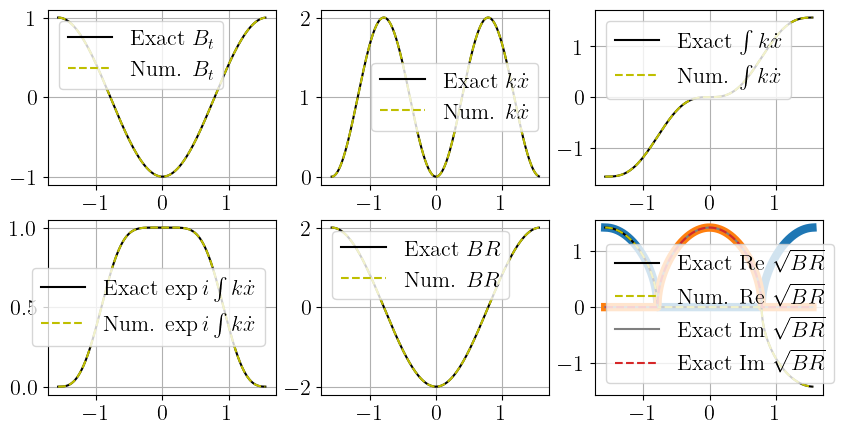

In [32]:
import util as ut
from scipy.integrate import cumulative_trapezoid

xs_dot_ex = lambda t: - 2 * R * np.sin(2*t)
int_k_xdot_ex = lambda t: (t * (R**2) - (R**2)/4 * np.sin(4*t))
exp_i_int_k_xdot_ex = lambda t: np.exp(1j * (t * (R**2) - (R**2)/4 * np.sin(4*t)))

k_xdot_num = ut.inner_product(fd.grad(xs.squeeze(), t)[..., np.newaxis], ks)
int_k_xdot_num = cumulative_trapezoid(k_xdot_num, t, initial=0, axis=0)
int_k_xdot_num = int_k_xdot_num - int_k_xdot_num[t==0]

sqrt_body_ex = lambda t: - 2 * R * np.cos(2*t)
sqrt_body_num = np.sign(mgo_info['S'][:, 0, 1].squeeze())*np.abs(np.linalg.det(mgo_info['Lambda_rhos']) * np.linalg.det(mgo_info['A_zetas'])) * np.linalg.det(mgo_info['R'])

fig, ax = plt.subplots(2, 3, figsize=(10, 5))

ax[0, 0].plot(t, B_ex(t), 'k-', label=r'Exact $B_t$')
ax[0, 0].plot(t, mgo_info['S'][:, 0, 1], 'y--', label=r'Num. $B_t$')
ax[0, 0].legend()
ax[0, 0].grid()

ax[0, 1].plot(t, ks_ex(t)*xs_dot_ex(t), 'k-', label=r'Exact $k \dot{x}$')
ax[0, 1].plot(t, ut.inner_product(fd.grad(xs.squeeze(), t)[..., np.newaxis], ks), 'y--', label=r'Num. $k \dot{x}$')
ax[0, 1].legend()
ax[0, 1].grid()

ax[0, 2].plot(t, int_k_xdot_ex(t), 'k-', label=r'Exact $\int k \dot{x}$')
ax[0, 2].plot(t, int_k_xdot_num, 'y--', label=r'Num. $\int  k \dot{x}$')
ax[0, 2].legend()
ax[0, 2].grid()

ax[1, 0].plot(t, exp_i_int_k_xdot_ex(t), 'k-', label=r'Exact $\exp i \int k \dot{x}$')
ax[1, 0].plot(t, np.exp(1j * int_k_xdot_num), 'y--', label=r'Num. $\exp i \int k \dot{x}$')
ax[1, 0].legend()
ax[1, 0].grid()

ax[1, 1].plot(t, sqrt_body_ex(t), 'k-', label=r'Exact $BR$')
ax[1, 1].plot(t, sqrt_body_num, 'y--', label=r'Num. $BR$')
ax[1, 1].legend()
ax[1, 1].grid()

ax[1, 2].plot(t, np.real(np.emath.sqrt(sqrt_body_ex(t))), '-', linewidth=6)
ax[1, 2].plot(t, np.imag(np.emath.sqrt(sqrt_body_num)), '-', linewidth=6)
ax[1, 2].plot(t, np.real(ut.continuous_sqrt_of_reals(sqrt_body_ex(t))), 'k-', label=r'Exact Re $\sqrt{BR}$')
ax[1, 2].plot(t, np.real(ut.continuous_sqrt_of_reals(sqrt_body_num)), 'y--', label=r'Num. Re $\sqrt{BR}$')
ax[1, 2].plot(t, np.imag(ut.continuous_sqrt_of_reals(sqrt_body_ex(t))), '-', color='tab:grey', label=r'Exact Im $\sqrt{BR}$')
ax[1, 2].plot(t, np.imag(ut.continuous_sqrt_of_reals(sqrt_body_num)), '--', color='tab:red', label=r'Exact Im $\sqrt{BR}$')
ax[1, 2].legend()
ax[1, 2].grid()

plt.show()